<a href="https://colab.research.google.com/github/cfitzpatrick89/ADS509-Final/blob/main/ADS509_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xmltodict
!pip install pyLDAvis

import pandas as pd
import xmltodict
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
import json
from sklearn.decomposition import NMF
import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim_models
from sklearn.cluster import KMeans

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import nltk
nltk.download('vader_lexicon')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create Directory

In [3]:
# Function to create a directory
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pubmed IDs

In [4]:
import requests

def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []

# Example usage:
pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def fetch_pubmed_details(ids, batch_size=100):
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    xml_data_list = []
    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        fetch_params = {
            "db": "pubmed",
            "id": ",".join(batch_ids),
            "retmode": "xml"
        }
        response = requests.get(fetch_url, params=fetch_params)
        if response.status_code == 200:
            xml_data_list.append(response.text)
        else:
            print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
    return xml_data_list

# Example usage:
pubmed_xml = fetch_pubmed_details(pubmed_ids)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Parse Data

In [6]:
import xmltodict

def extract_text_from_abstract(abstract):
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        return ' '.join(text_list)
    elif isinstance(abstract, dict):
        return abstract.get('#text', '')
    else:
        return abstract

def parse_pubmed_details(xml_data_list):
    articles = []
    for xml_data in xml_data_list:
        data_dict = xmltodict.parse(xml_data)
        for article in data_dict['PubmedArticleSet']['PubmedArticle']:
            try:
                pmid = article['MedlineCitation']['PMID']
                title = article['MedlineCitation']['Article']['ArticleTitle']
                abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
                abstract_text = extract_text_from_abstract(abstract)
                articles.append({
                    'PMID': pmid,
                    'Title': title,
                    'Abstract': abstract_text
                })
            except KeyError:
                continue
    return articles

# Example usage:
articles = parse_pubmed_details(pubmed_xml)
df_articles = pd.DataFrame(articles)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# # Function to extract text from abstract field in different formats
# def extract_text_from_abstract(abstract):
#     print(f"Extracting text from abstract: {abstract}")  # Debug statement
#     if isinstance(abstract, list):
#         text_list = []
#         for item in abstract:
#             if isinstance(item, dict):
#                 text_list.append(item.get('#text', ''))
#             else:
#                 text_list.append(item)
#         extracted_text = ' '.join(text_list)
#     elif isinstance(abstract, dict):
#         extracted_text = abstract.get('#text', '')
#     else:
#         extracted_text = abstract
#     print(f"Extracted text: {extracted_text[:60]}...")  # Debug statement
#     return extracted_text

# # Function to parse PubMed XML Data in batches
# def parse_pubmed_details(xml_data_list):
#     articles = []
#     for batch_index, xml_data in enumerate(xml_data_list):
#         try:
#             print(f"Parsing batch {batch_index + 1}/{len(xml_data_list)}")  # Debug statement
#             data_dict = xmltodict.parse(xml_data)
#             for article in data_dict['PubmedArticleSet']['PubmedArticle']:
#                 try:
#                     pmid = article['MedlineCitation']['PMID']
#                     title = article['MedlineCitation']['Article']['ArticleTitle']
#                     abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
#                     abstract_text = extract_text_from_abstract(abstract)
#                     articles.append({
#                         'PMID': pmid,
#                         'Title': title,
#                         'Abstract': abstract_text
#                     })
#                     print(f"Article parsed: PMID {pmid}, Title {title[:60]}...")  # Debug statement
#                 except KeyError as e:
#                     print(f"KeyError: {e} - Skipping article")  # Debug statement
#                     continue
#         except Exception as e:
#             print(f"Error parsing XML: {e} - Skipping batch")  # Debug statement
#             continue
#     return articles



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Preprocess Text

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Example usage:
df_articles['processed_abstract'] = df_articles['Abstract'].apply(preprocess_text)
df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# # Function to preprocess text without debug output
# def preprocess_text(text):
#     tokens = word_tokenize(text)
#     tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
#     return tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# # Function to preprocess text
# def preprocess_text(text):
#     print(f"Preprocessing text: {text[:60]}...")  # Print the first 60 characters of the text for debugging
#     tokens = word_tokenize(text)  # Tokenize the text
#     print(f"Tokens: {tokens[:10]}...")  # Print the first 10 tokens for debugging
#     tokens = [word.lower() for word in tokens]  # Convert tokens to lowercase
#     print(f"Lowercased Tokens: {tokens[:10]}...")  # Print the first 10 lowercased tokens for debugging
#     tokens = [word for word in tokens if word.isalpha()]  # Remove tokens that contain non-alphabetic characters
#     print(f"Alphabetic Tokens: {tokens[:10]}...")  # Print the first 10 alphabetic tokens for debugging
#     tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
#     print(f"Tokens without Stopwords: {tokens[:10]}...")  # Print the first 10 tokens without stopwords for debugging
#     return tokens



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Descriptive Statistics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of tokens: 12966
Number of unique tokens: 3782
Average token length: 7.28
Most common tokens: [('health', 181), ('climate', 179), ('the', 137), ('change', 137), ('we', 84), ('research', 70), ('heat', 62), ('study', 54), ('exposure', 54), ('temperature', 52)]


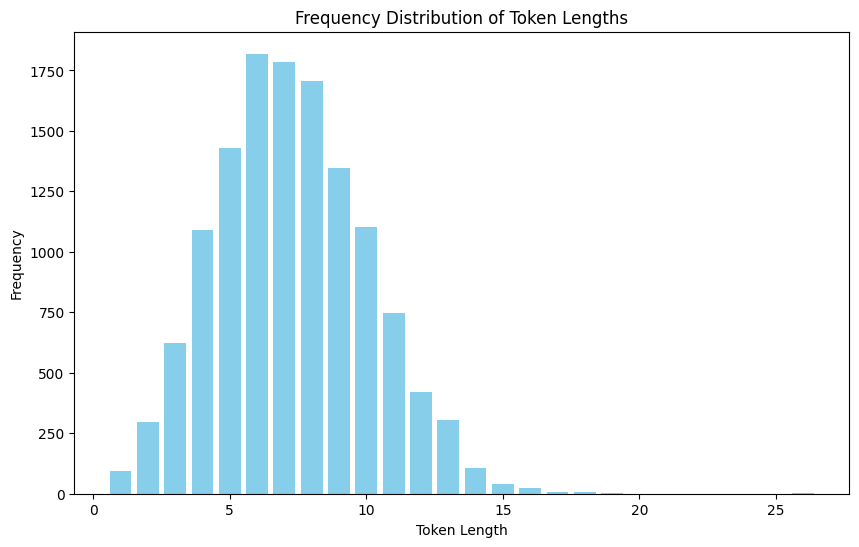

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def calculate_descriptive_statistics(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)
    num_tokens = len(tokens)
    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)
    avg_token_length = sum(len(token) for token in tokens) / num_tokens
    token_freq = Counter(tokens)
    most_common_tokens = token_freq.most_common(10)
    token_length_freq = Counter(len(token) for token in tokens)

    print(f"Number of tokens: {num_tokens}")
    print(f"Number of unique tokens: {num_unique_tokens}")
    print(f"Average token length: {avg_token_length:.2f}")
    print(f"Most common tokens: {most_common_tokens}")

    token_length_df = pd.DataFrame(token_length_freq.items(), columns=['Token Length', 'Frequency']).sort_values(by='Token Length')
    return token_length_df

# Example usage:
token_length_df = calculate_descriptive_statistics(df_articles, 'processed_abstract_str')

# Plot the frequency distribution of token lengths
plt.figure(figsize=(10, 6))
plt.bar(token_length_df['Token Length'], token_length_df['Frequency'], color='skyblue')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Token Lengths')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average number of unique tokens per abstract: 100.38
Average sentence length: 137.94 tokens


<ipython-input-12-b635a2211675>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Frequency', data=token_freq_df, palette='viridis')


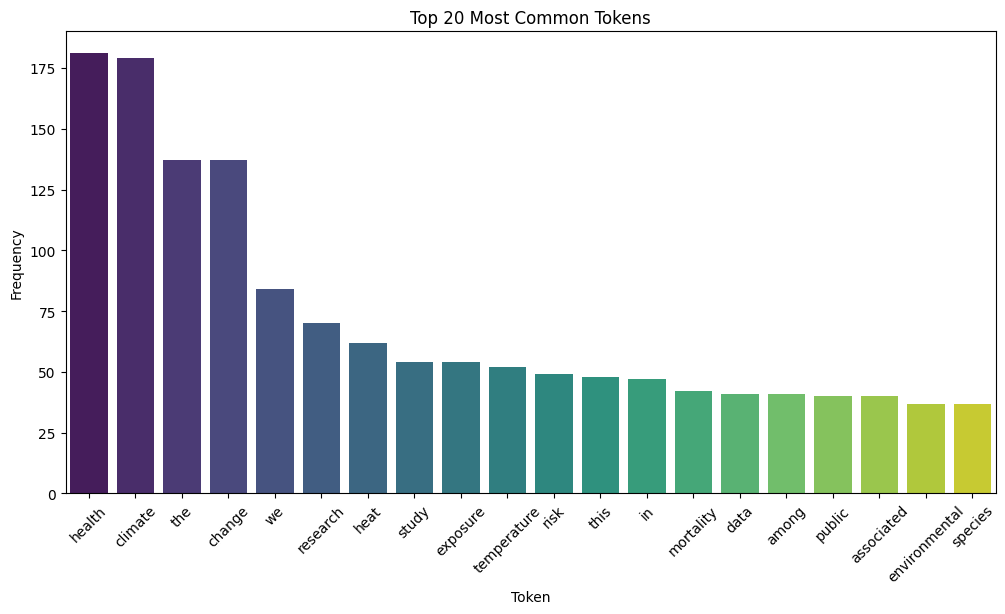

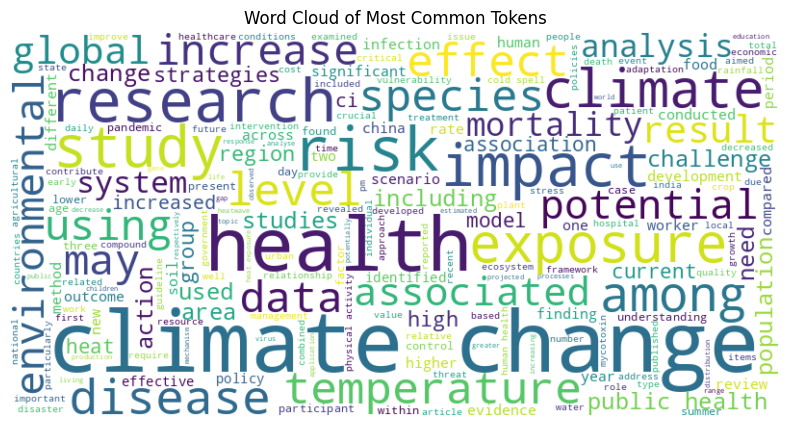

In [12]:
import numpy as np
from wordcloud import WordCloud

def calculate_advanced_statistics(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)

    # Token frequency distribution
    token_freq = Counter(tokens)

    # Unique tokens per abstract
    df['unique_tokens'] = df[text_column].apply(lambda x: len(set(word_tokenize(x))))
    avg_unique_tokens = df['unique_tokens'].mean()

    # Average sentence length
    sentences = [sentence for text in df[text_column] for sentence in text.split('.')]
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    avg_sentence_length = np.mean(sentence_lengths)

    # Display results
    print(f"Average number of unique tokens per abstract: {avg_unique_tokens:.2f}")
    print(f"Average sentence length: {avg_sentence_length:.2f} tokens")

    # Token frequency distribution plot
    token_freq_df = pd.DataFrame(token_freq.most_common(20), columns=['Token', 'Frequency'])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Token', y='Frequency', data=token_freq_df, palette='viridis')
    plt.xlabel('Token')
    plt.ylabel('Frequency')
    plt.title('Top 20 Most Common Tokens')
    plt.xticks(rotation=45)
    plt.show()

    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Most Common Tokens')
    plt.show()

    return avg_unique_tokens, avg_sentence_length

# Example usage:
if df_articles is not None:
    df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))
    avg_unique_tokens, avg_sentence_length = calculate_advanced_statistics(df_articles, 'processed_abstract_str')
else:
    print("DataFrame is empty. No articles to process.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


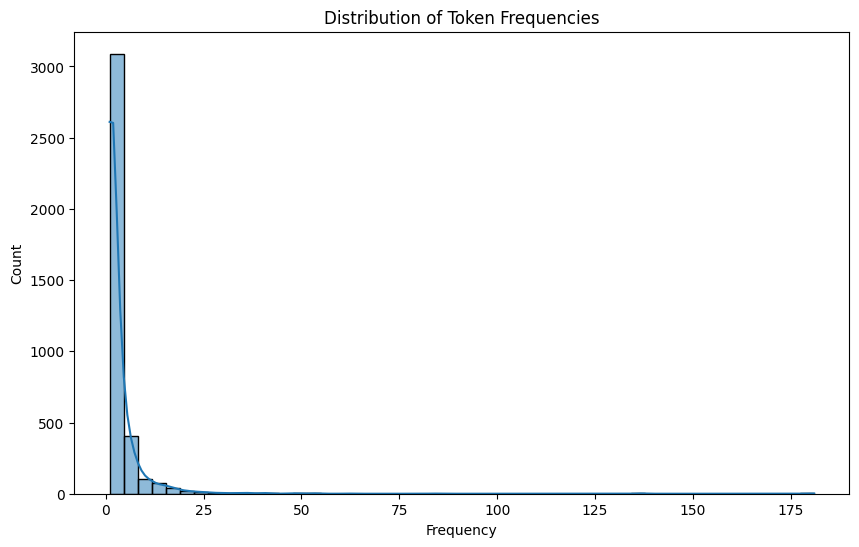

In [13]:
def plot_token_frequencies(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)
    token_freq = Counter(tokens)

    token_freq_df = pd.DataFrame(token_freq.values(), columns=['Frequency'])
    plt.figure(figsize=(10, 6))
    sns.histplot(token_freq_df['Frequency'], bins=50, kde=True)
    plt.xlabel('Frequency')
    plt.ylabel('Count')
    plt.title('Distribution of Token Frequencies')
    plt.show()

# Example usage:
plot_token_frequencies(df_articles, 'processed_abstract_str')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


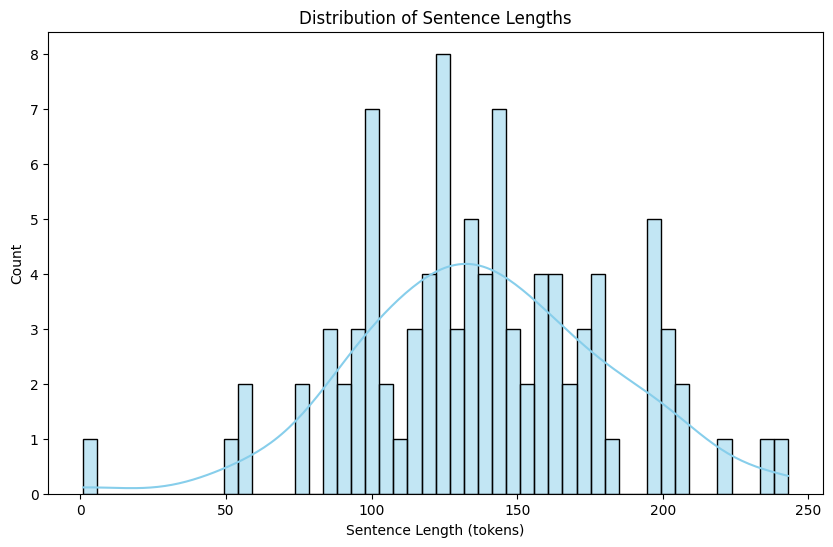

In [14]:
def plot_sentence_lengths(df, text_column):
    sentences = [sentence for text in df[text_column] for sentence in text.split('.')]
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]

    plt.figure(figsize=(10, 6))
    sns.histplot(sentence_lengths, bins=50, kde=True, color='skyblue')
    plt.xlabel('Sentence Length (tokens)')
    plt.ylabel('Count')
    plt.title('Distribution of Sentence Lengths')
    plt.show()

# Example usage:
plot_sentence_lengths(df_articles, 'processed_abstract_str')


## Topic Modeling

In [15]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Ensure we have TF-IDF and NMF installed
!pip install scikit-learn
!pip install xmltodict

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic Modeling Functions

In [16]:

def nmf_topic_modeling(text_data, num_topics=5, num_top_words=10):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(text_data)
    nmf = NMF(n_components=num_topics, random_state=1)
    nmf.fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([tfidf_feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

def lda_topic_modeling(text_data, num_topics=5, num_top_words=10):
    count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    count_data = count_vectorizer.fit_transform(text_data)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=1)
    lda.fit(count_data)
    count_feature_names = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([count_feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

def lsa_topic_modeling(text_data, num_topics=5, num_top_words=10):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(text_data)
    lsa = TruncatedSVD(n_components=num_topics, random_state=1)
    lsa.fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lsa.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([tfidf_feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

def visualize_lda_topics(text_data, num_topics=5):
    count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    count_data = count_vectorizer.fit_transform(text_data)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=1)
    lda.fit(count_data)
    panel = pyLDAvis.lda_model.prepare(lda, count_data, count_vectorizer, mds='tsne')
    pyLDAvis.display(panel)
    return panel


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### NMF

In [17]:
nmf_topic_modeling(df_articles['processed_abstract_str'], num_topics=5, num_top_words=10)

Topic 1:
health climate adaptation research change policy strategies services environmental challenges
Topic 2:
temperature cold mortality heat risk china days spells ci waves
Topic 3:
species soil plant growth compounds stress food change study germination
Topic 4:
virus cases diagnosis arbovirus disease risk new infection countries vectors
Topic 5:
exposure workers levels associated heat birth skin pm air age


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

lda_topic_modeling(df_articles['processed_abstract_str'], num_topics=5, num_top_words=10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1:
health temperature climate associated heat mortality change exposure rainfall workers
Topic 2:
pm research change climate exposure levels illness mental future potential
Topic 3:
climate change exposure increase health development disease risk soil plant
Topic 4:
heat study health risk impact adults skin stress change climate
Topic 5:
health climate change research adaptation public global environmental study strategies


### LSA

In [21]:
from sklearn.decomposition import TruncatedSVD
lsa_topic_modeling(df_articles['processed_abstract_str'], num_topics=5, num_top_words=10)


Topic 1:
health climate change heat research temperature adaptation exposure risk mortality
Topic 2:
temperature heat cold risk exposure mortality days association ci china
Topic 3:
species soil plant compounds growth stress water genes method germination
Topic 4:
virus cases exposure disease new infection diagnosis research countries samples
Topic 5:
workers levels exposure associated skin soil workplace age dna air


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA Panel

In [23]:
import pyLDAvis.lda_model

lda_panel = visualize_lda_topics(df_articles['processed_abstract_str'], num_topics=5)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
import pyLDAvis

# Enable notebook mode for pyLDAvis
pyLDAvis.enable_notebook()

# Display the LDA visualization panel
pyLDAvis.display(lda_panel)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Sentiment Analysis

In [40]:
def sentiment_analysis(text_data):
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()

    # Create a list to store sentiment scores
    sentiments = []

    # Loop through the text data
    for text in text_data:
        # Calculate sentiment scores
        sentiment_scores = sid.polarity_scores(text)
        sentiments.append(sentiment_scores)

    return sentiments

# Perform sentiment analysis
sentiment_scores = sentiment_analysis(df_articles['processed_abstract_str'])

# Convert the sentiment scores to a DataFrame
df_sentiments = pd.DataFrame(sentiment_scores)

# Combine the sentiment scores with the original DataFrame
df_combined = pd.concat([df_articles, df_sentiments], axis=1)

# Display the DataFrame with sentiment scores
print(df_combined.head())


#def sentiment_analysis(text_data):
#     # Initialize VADER sentiment analyzer
#     sid = SentimentIntensityAnalyzer()

#     # Create a list to store sentiment scores
#     sentiments = []

#     # Loop through the text data
#     for text in text_data:
#         # Calculate sentiment scores
#         sentiment_scores = sid.polarity_scores(text)
#         sentiments.append(sentiment_scores)

#     return sentiments

# # Example usage
# sentiment_scores = sentiment_analysis(df_articles['processed_abstract_str'])

# # Convert the sentiment scores to a DataFrame
# df_sentiments = pd.DataFrame(sentiment_scores)

# # Combine the sentiment scores with the original DataFrame
# df_combined = pd.concat([df_articles, df_sentiments], axis=1)

# # # Display the DataFrame with sentiment scores
# # print(df_combined.head())



                                     PMID  \
0  {'@Version': '1', '#text': '38156221'}   
1  {'@Version': '1', '#text': '38155328'}   
2  {'@Version': '1', '#text': '38154019'}   
3  {'@Version': '1', '#text': '38153962'}   
4  {'@Version': '1', '#text': '38153847'}   

                                               Title  \
0  Perspectives on research needs in healthcare e...   
1  Reducing the carbon footprint of cataract surg...   
2  Assessing Support for Policy Actions With Co-B...   
3  Heat Exposure among Adult Women in Rural Tamil...   
4  Physiological responses to 9 hours of heat exp...   

                                            Abstract  \
0  In this overview, we articulate research needs...   
1  Climate change is arguably the greatest threat...   
2  Calls to action addressing the interconnection...   
3  Exposure to heat is associated with a substant...   
4  Older adults are at greater risk of heat-relat...   

                                             Journal  \

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


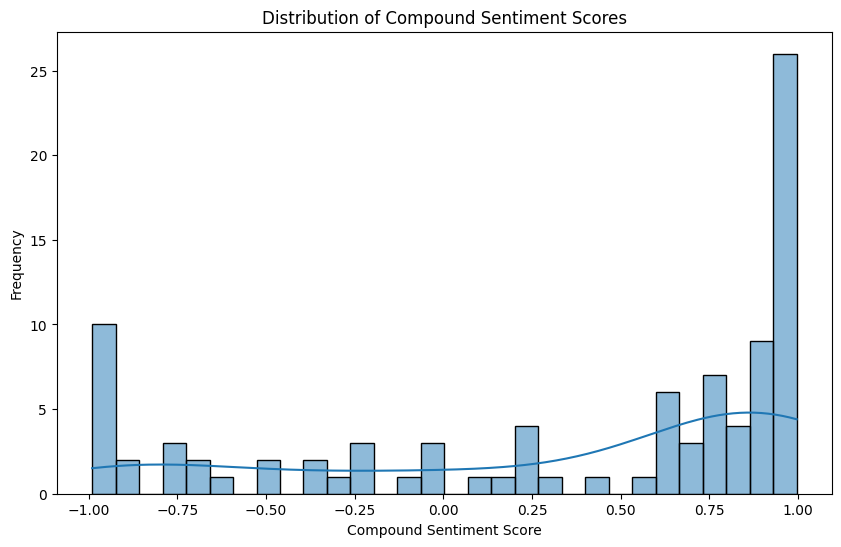

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_sentiment(df):
    plt.figure(figsize=(10, 6))

    # Plotting the distribution of sentiment scores
    sns.histplot(df['compound'], bins=30, kde=True)
    plt.title('Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Frequency')

    plt.show()

# Example usage
visualize_sentiment(df_combined)


### Top Keywords

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=top_n)
    X = vectorizer.fit_transform(texts)
    keywords = vectorizer.get_feature_names_out()
    return keywords

# Example usage
keywords = extract_keywords(df_articles['processed_abstract_str'], top_n=20)
print("Top Keywords:", keywords)


Top Keywords: ['associated' 'change' 'climate' 'data' 'environmental' 'exposure'
 'global' 'health' 'heat' 'impact' 'levels' 'mortality' 'potential'
 'public' 'research' 'risk' 'species' 'study' 'temperature' 'using']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# import pandas as pd
# import xmltodict
# import requests
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# import pyLDAvis
# import pyLDAvis.lda_model
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Ensure NLTK resources are downloaded
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

# stop_words = set(stopwords.words('english'))

# def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
#     search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
#     search_params = {
#         "db": "pubmed",
#         "term": query,
#         "retmode": "json",
#         "retmax": max_results,
#         "mindate": from_date,
#         "maxdate": to_date
#     }
#     response = requests.get(search_url, params=search_params)
#     if response.status_code == 200:
#         data = response.json()
#         return data['esearchresult']['idlist']
#     else:
#         print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
#         return []

# def fetch_pubmed_details(ids, batch_size=100):
#     fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
#     xml_data_list = []
#     for i in range(0, len(ids), batch_size):
#         batch_ids = ids[i:i + batch_size]
#         fetch_params = {
#             "db": "pubmed",
#             "id": ",".join(batch_ids),
#             "retmode": "xml"
#         }
#         response = requests.get(fetch_url, params=fetch_params)
#         if response.status_code == 200:
#             xml_data_list.append(response.text)
#         else:
#             print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
#     return xml_data_list

# def extract_text_from_abstract(abstract):
#     if isinstance(abstract, list):
#         text_list = []
#         for item in abstract:
#             if isinstance(item, dict):
#                 text_list.append(item.get('#text', ''))
#             else:
#                 text_list.append(item)
#         return ' '.join(text_list)
#     elif isinstance(abstract, dict):
#         return abstract.get('#text', '')
#     else:
#         return abstract

# def parse_pubmed_details(xml_data_list):
#     articles = []
#     for xml_data in xml_data_list:
#         data_dict = xmltodict.parse(xml_data)
#         for article in data_dict['PubmedArticleSet']['PubmedArticle']:
#             try:
#                 pmid = article['MedlineCitation']['PMID']
#                 title = article['MedlineCitation']['Article']['ArticleTitle']
#                 abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
#                 abstract_text = extract_text_from_abstract(abstract)
#                 journal = article['MedlineCitation']['Article']['Journal']['Title']
#                 articles.append({
#                     'PMID': pmid,
#                     'Title': title,
#                     'Abstract': abstract_text,
#                     'Journal': journal
#                 })
#             except KeyError:
#                 continue
#     return articles

# def preprocess_text(text):
#     tokens = word_tokenize(text)
#     tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
#     return tokens

# # Fetch PubMed IDs and details
# pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31')
# pubmed_xml = fetch_pubmed_details(pubmed_ids)
# articles = parse_pubmed_details(pubmed_xml)
# df_articles = pd.DataFrame(articles)

# # Preprocess text
# df_articles['processed_abstract'] = df_articles['Abstract'].apply(preprocess_text)
# df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Sentiment Scores by Journal

In [34]:
# Calculate the average sentiment scores by journal
journal_sentiment = df_combined.groupby('Journal')['compound'].mean().reset_index()

# Sort the journals by average sentiment score
journal_sentiment_sorted = journal_sentiment.sort_values(by='compound', ascending=False)

# Display the top 5 journals with the highest sentiment scores
print("Top 5 Journals with Highest Sentiment Scores:")
print(journal_sentiment_sorted.head(5))

# Display the top 5 journals with the lowest sentiment scores
print("Top 5 Journals with Lowest Sentiment Scores:")
print(journal_sentiment_sorted.tail(5))


Top 5 Journals with Highest Sentiment Scores:
                                        Journal  compound
37  International journal of health geographics    0.9965
15                                Data in brief    0.9910
71              Yearbook of medical informatics    0.9900
20        Environmental geochemistry and health    0.9874
40                      Journal of agromedicine    0.9814
Top 5 Journals with Lowest Sentiment Scores:
                                              Journal  compound
6                              BMC pulmonary medicine   -0.9287
41  Journal of applied physiology (Bethesda, Md. :...   -0.9403
53                One health (Amsterdam, Netherlands)   -0.9442
59                                Psychiatry research   -0.9701
70                Western journal of nursing research   -0.9905


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-35-9461ef68107b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='compound', y='Journal', data=top_journals, palette='viridis')


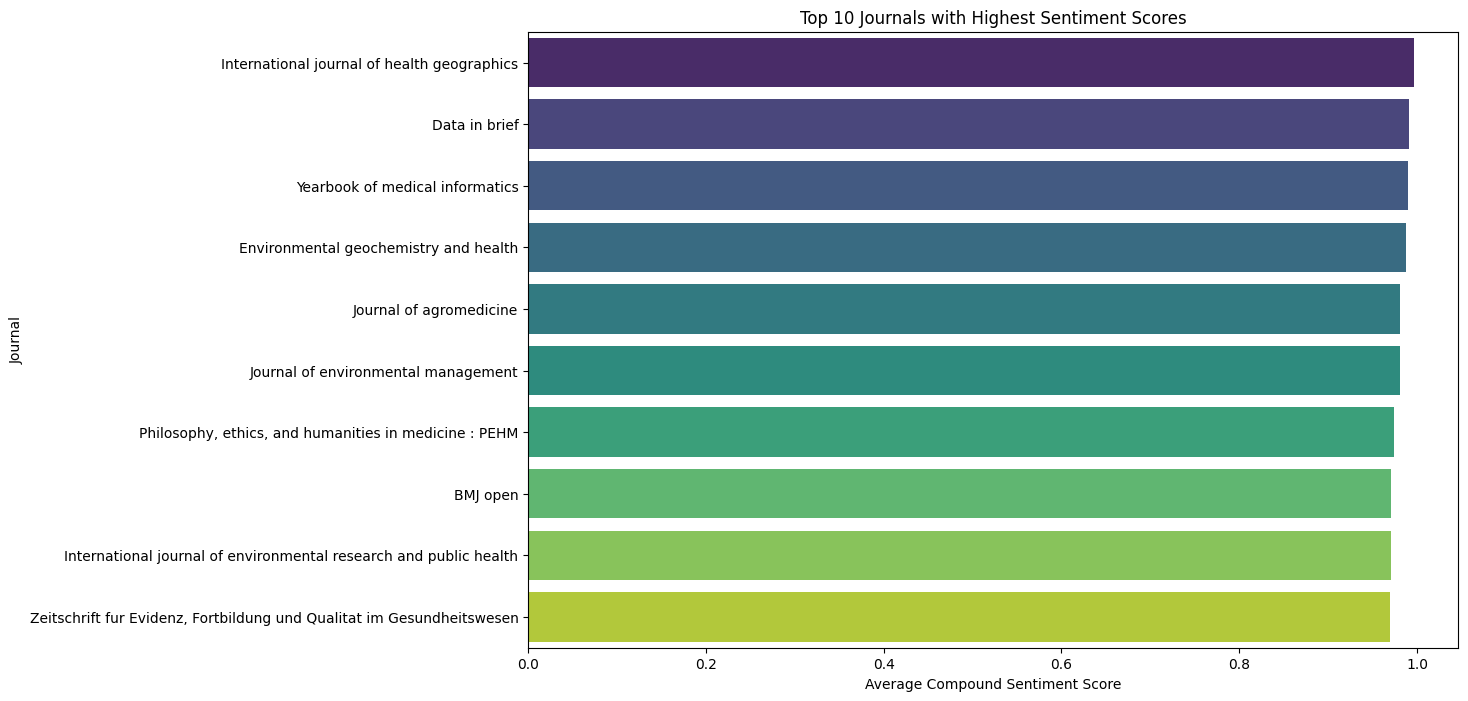

<ipython-input-35-9461ef68107b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='compound', y='Journal', data=bottom_journals, palette='viridis')


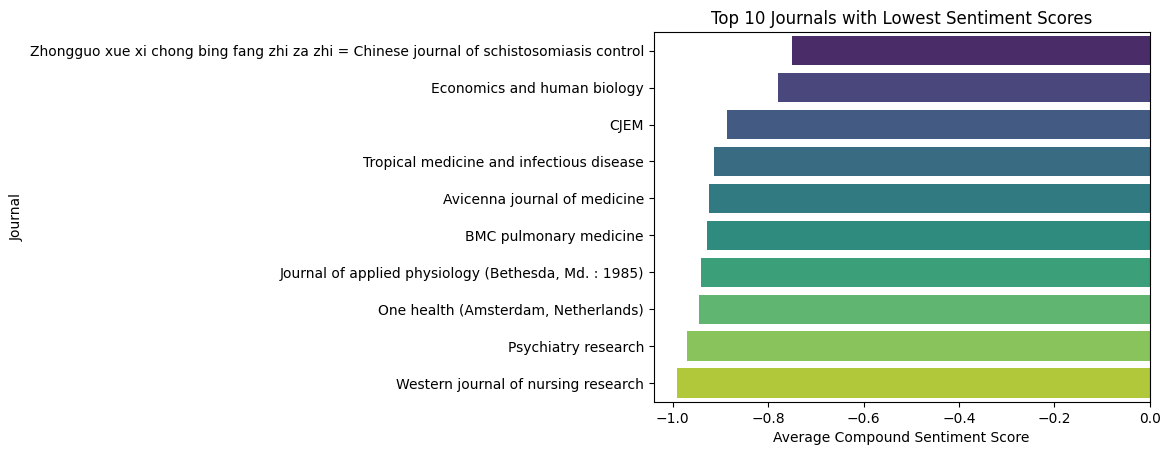

In [35]:
def visualize_journal_sentiment(journal_sentiment):
    plt.figure(figsize=(12, 8))

    # Plotting the top 10 journals with highest sentiment scores
    top_journals = journal_sentiment_sorted.head(10)
    sns.barplot(x='compound', y='Journal', data=top_journals, palette='viridis')
    plt.title('Top 10 Journals with Highest Sentiment Scores')
    plt.xlabel('Average Compound Sentiment Score')
    plt.ylabel('Journal')
    plt.show()

    # Plotting the top 10 journals with lowest sentiment scores
    bottom_journals = journal_sentiment_sorted.tail(10)
    sns.barplot(x='compound', y='Journal', data=bottom_journals, palette='viridis')
    plt.title('Top 10 Journals with Lowest Sentiment Scores')
    plt.xlabel('Average Compound Sentiment Score')
    plt.ylabel('Journal')
    plt.show()

# Example usage
visualize_journal_sentiment(journal_sentiment_sorted)



### Negative and Positive Sentiment Words

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


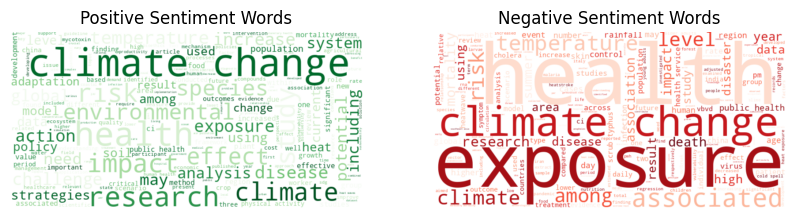

In [37]:
from wordcloud import WordCloud

def generate_word_clouds(df):
    positive_texts = ' '.join(df[df['compound'] > 0]['processed_abstract_str'])
    negative_texts = ' '.join(df[df['compound'] < 0]['processed_abstract_str'])

    wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_texts)
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_texts)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive Sentiment Words')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Negative Sentiment Words')

    plt.show()

# Example usage
generate_word_clouds(df_combined)


### Top Positive and Negative Abstracts

In [38]:
def show_examples(df, sentiment_type='positive', top_n=5):
    if sentiment_type == 'positive':
        examples = df.nlargest(top_n, 'compound')
    else:
        examples = df.nsmallest(top_n, 'compound')

    for index, row in examples.iterrows():
        print(f"Journal: {row['Journal']}")
        print(f"Title: {row['Title']}")
        print(f"Abstract: {row['Abstract']}")
        print(f"Sentiment Score: {row['compound']}")
        print("Highlighted Abstract:")
        display(HTML(f"<p>{row['highlighted_abstract']}</p>"))
        print("="*80)

# Example usage
print("Top Positive Sentiment Abstracts:")
show_examples(df_combined, sentiment_type='positive', top_n=3)

print("Top Negative Sentiment Abstracts:")
show_examples(df_combined, sentiment_type='negative', top_n=3)


Top Positive Sentiment Abstracts:
Journal: International journal of health geographics
Title: Using geographic rescue time contours, point-of-care strategies, and spatial care paths to prepare island communities for global warming, rising oceans, and weather disasters.
Abstract: To perform geographic contour analysis of sea and land ambulance rescue times in an archipelago subject to super typhoons; to design point-of-care testing strategies for medical emergencies and weather disasters made more intense by global warming and rising oceans; and to assess needs for prehospital testing on spatial care paths that accelerate decision making, increase efficiency, improve outcomes, and enhance standards of care in island nations. We performed needs assessments, inspected healthcare facilities, and collected ambulance rescue times from professionals in the Bantayan Archipelago, Philippines. We mapped sea/land ambulance rescue routes and time contours. To reveal gaps, we statistically compared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Journal: Environmental science and pollution research international
Title: Unraveling interactions and priorities under sustainable development goals in less-developed mountainous areas: case study on the National Innovation Demonstration Zone for the 2030 Agenda for Sustainable Development, China.
Abstract: Understanding the intricate relationships between progress and the United Nations' 17 Sustainable Development Goals (SDGs) is vital for informed and adaptable sustainable development policy formulation. This study focused on the Lincang National Innovation Demonstration Zone for the 2030 Agenda for Sustainable Development (LC-NIDZASD) in China. By evaluating sustainability scores at the county level from 2011 to 2020, the trade-offs and synergies among SDGs were explored. Priority SDGs for development were identified, and targeted recommendations were established based on these findings. The key findings are as follows: (1) The SDG index scores of Lincang and its counties showed an

Journal: Data in brief
Title: Twitter dataset on public sentiments towards biodiversity policy in Indonesia.
Abstract: In recent years, biodiversity has emerged as a prominent and pressing topic due to the urgent need to address biodiversity loss and the recognition of its connections to climate change and sustainable development. Additionally, increased public awareness and the consideration of economic factors have further underscored the significance of biodiversity conservation. To investigate the sentiment of the Indonesian people towards biodiversity, we conducted a comprehensive data collection on Twitter, focusing on keywords we have set. We amassed a substantial dataset of 500,000 Indonesian tweets from January 2020 to March 2023. These tweets encompassed a wide range of discussions on biodiversity, including its subdomains such as food security, health, and environmental management. Three annotators labeled each tweet with a sentiment class (positive, negative, neutral), or l

Top Negative Sentiment Abstracts:
Journal: Western journal of nursing research
Title: Cognitive Interview Validation of a Novel Household Hazard Vulnerability Assessment Instrument.
Abstract: Weather and climate disasters are responsible for over 13 000 US deaths, worsened morbidity, and $1.7 trillion in additional costs over the last 40 years with profound racial disparities. This project empirically generated items for a novel survey instrument of household hazard vulnerability with initial construct validation while addressing racial bias in the data collection process. Cognitive interviews facilitated understanding regarding the performance of drafted survey questions with transdisciplinary expert panelists from diverse US regions on unique hazard/disaster/event items. To prevent representation bias in data collection, those with Black and/or African American racial, biracial, or multiracial identities were over-sampled. Interview video recordings were qualitatively analyzed using 

Journal: Environmental science & technology
Title: Excess Mortality Risk Due to Heat Stress in Different Climatic Zones of India.
Abstract: India is at a high risk of heat stress-induced health impacts and economic losses owing to its tropical climate, high population density, and inadequate adaptive planning. The health impacts of heat stress across climate zones in India have not been adequately explored. Here, we examine and report the vulnerability to heat stress in India using 42 years (1979-2020) of meteorological data from ERA-5 and developed climate-zone-specific percentile-based human comfort class thresholds. We found that the heat stress is usually 1-4 °C higher on heatwave (HW) days than on nonheatwave (NHW) days. However, the stress on NHW days remains considerable and cannot be neglected. We then showed the association of a newly formulated India heat index (IHI) with daily all-cause mortality in three cities - Delhi (semiarid), Varanasi (humid subtropical), and Chennai (

Journal: Psychiatry research
Title: Mental illness and increased vulnerability to negative health effects from extreme heat events: a systematic review.
Abstract: Across countries, extreme heat events are projected to increase in frequency and intensity because of climate change. Exposure to extreme heat events can have a substantial negative impact on human health, and extant research suggests that individuals with mental illness are particularly vulnerable. To date, there has been no review of evidence regarding this vulnerability to inform response strategies and future research. A systematic review was undertaken to investigate mental illness as an effect modifier of the relationship between heat exposure and morbidity or mortality. Six databases (Medline, Embase, Global Health, PsychInfo, CINAHL and Scopus) were searched for studies published between the years 2000 to 2022. Twenty-two observational studies that met the inclusion criteria were investigated through narrative synthes